Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jyots\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data Collection

In [2]:
df=pd.read_csv('vaccination_tweets.csv')

Data Preprocessing

In [3]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10340 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [5]:
df.isnull().sum()

id                     0
user_name              0
user_location       2270
user_description     680
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [6]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [7]:
# dropping all col except text col
text_df=df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'], axis=1)
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [8]:
df.shape

(11020, 16)

In [9]:
print(text_df['text'].iloc[0],"\n")

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 



In [10]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11020 non-null  object
dtypes: object(1)
memory usage: 86.2+ KB


Text Cleaning

In [11]:
# function to remove url, hastags and punctuations using the regex func
def data_preprocessing(text):
    text=text.lower()
    text=re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text=re.sub(r'\@w+|\#','',text)
    text=re.sub(r'[^\w\s]','',text)
    text_tokens=word_tokenize(text)
    filtered_text=[w for w in text_tokens if not w in stop_words]  # remove stopwords
    return " ".join(filtered_text)  # join tokens back into single string and return

In [12]:
text_df.text=text_df['text'].apply(data_preprocessing)

In [13]:
# remove duplicate data
text_df=text_df.drop_duplicates('text')

Stemming

In [14]:
# stemming
stemmer=PorterStemmer()
def stemming(data):
    text=[stemmer.stem(word) for word in data]
    return data

In [15]:
text_df['text']=text_df['text'].apply(lambda x: stemming(x))

In [16]:
text_df.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...


In [17]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10543 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10543 non-null  object
dtypes: object(1)
memory usage: 164.7+ KB


Sentiment Calculation

In [18]:
# calculate text polarity using textblob
# how much +ve or -ve a text is
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [19]:
# cal polarity and adding to dataframe
text_df['polarity']=text_df['text'].apply(polarity)

In [20]:
text_df.head()

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.0
1,world wrong side history year hopefully bigges...,-0.5
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0
3,facts immutable senator even youre ethically s...,0.1
4,explain need vaccine borisjohnson matthancock ...,0.0


In [21]:
# calc sentiment
def sentiment(label):
    if label<0:
        return "Negative"
    elif label==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [22]:
text_df['sentiment']=text_df['polarity'].apply(sentiment)

In [23]:
text_df.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,facts immutable senator even youre ethically s...,0.1,Positive
4,explain need vaccine borisjohnson matthancock ...,0.0,Neutral


Visualizing Data Distribution

<Axes: xlabel='sentiment', ylabel='count'>

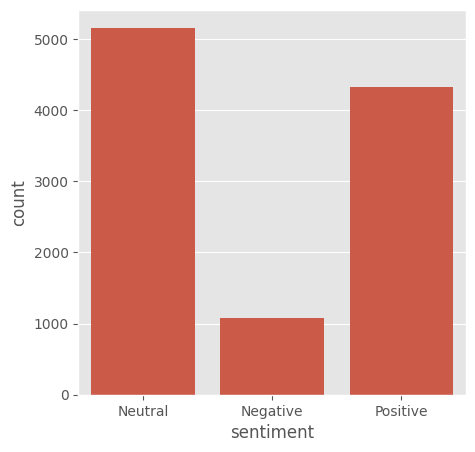

In [24]:
# visulaize data using count plot
fig=plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data=text_df)

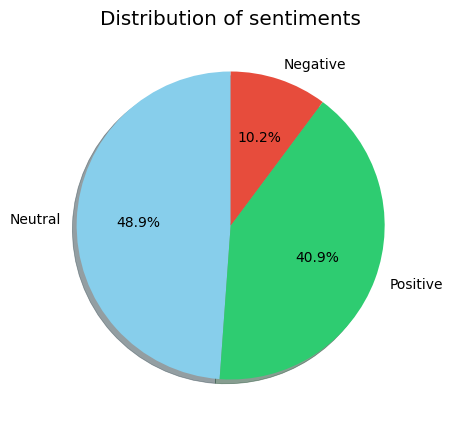

In [25]:
colors = ['#87CEEB', '#2ECC71', '#E74C3C']  # Light Blue, green, red
tags = text_df['sentiment'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(tags, labels=tags.index, autopct='%1.1f%%', shadow=True, colors=colors, startangle=90)
plt.title("Distribution of sentiments")
plt.show()



In [26]:
tags

sentiment
Neutral     5151
Positive    4317
Negative    1075
Name: count, dtype: int64

In [27]:
positive_tweets=text_df[text_df.sentiment=='Positive']
positive_tweets=positive_tweets.sort_values(['polarity'],ascending=False)
positive_tweets.head()

,text,polarity,sentiment
11,cnnbrk covid19 covidvaccine vaccine corona pfi...,1.0,Positive
10922,best day ever biggest sigh relief hope pray ev...,1.0,Positive
1287,excellent read pfizerbiontech covidvaccination,1.0,Positive
1428,check excellent resource vaccines amp immunity...,1.0,Positive
6378,cnn sputnikv vaccine seems best even doctors w...,1.0,Positive


Word Clouds

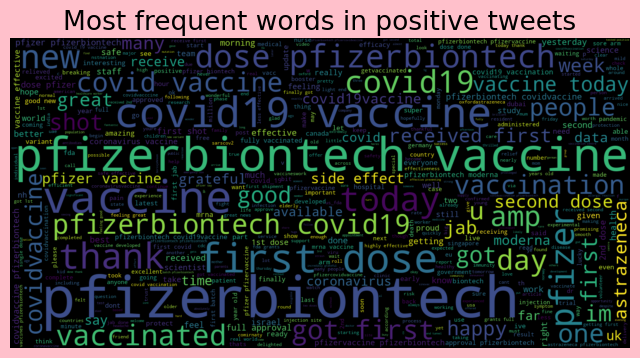

In [28]:
# word cloud to visualize all positive tweets
text=' '.join([word for word in positive_tweets['text']])
plt.figure(figsize=(8,8), facecolor='pink')
wordcloud=WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most frequent words in positive tweets",fontsize=19)
plt.show()

In [29]:
negative_tweets=text_df[text_df.sentiment=='Negative']
negative_tweets=negative_tweets.sort_values(['polarity'],ascending=False)
negative_tweets.head()

,text,polarity,sentiment
2912,work skilled nursing facility got first vaccin...,-0.003333,Negative
7256,200321 752308 vaccinations new daily record da...,-0.003409,Negative
2073,ukgovernment cant even vaccinate properly ethi...,-0.004762,Negative
7715,got first dose less waiting time airport vacci...,-0.005556,Negative
7157,nas_k27 second dose due end next month well fa...,-0.006250,Negative


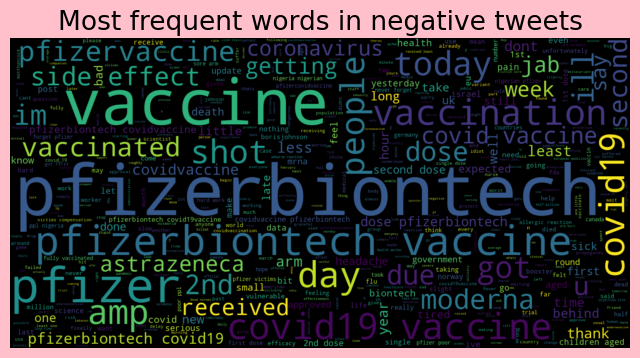

In [30]:
# word cloud to visualize all negative tweets
text=' '.join([word for word in negative_tweets['text']])
plt.figure(figsize=(8,8), facecolor='pink')
wordcloud=WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most frequent words in negative tweets",fontsize=19)
plt.show()

In [31]:
neutral_tweets=text_df[text_df.sentiment=='Neutral']
neutral_tweets=neutral_tweets.sort_values(['polarity'],ascending=False)
neutral_tweets.head()

,text,polarity,sentiment
11019,number covid19 cases today 15 november 2021 re...,0.0,Neutral
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
4,explain need vaccine borisjohnson matthancock ...,0.0,Neutral
8,covid vaccine getting covidvaccine covid19 pfi...,0.0,Neutral


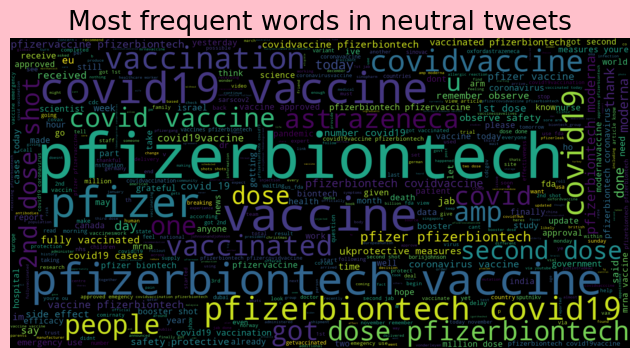

In [32]:
# word cloud to visualize all neutral tweets
text=' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(8,8), facecolor='pink')
wordcloud=WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most frequent words in neutral tweets",fontsize=19)
plt.show()

Feature Extraction

In [33]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])


In [34]:
# get the first 20 features 
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 78583

First 20 features:
 ['000' '000 doses' '000 initial' '000 people' '000 vaccines' '0000001'
 '0000001 covid19' '0011' '0011 abt' '004' '004 covid' '004 israelis' '01'
 '01 getting' '01 june' '01 november' '01aug2021' '01aug2021 doublevaxxed'
 '02' '02 175']


In [35]:
X=text_df['text']  # x=feature
Y=text_df['sentiment'] # y=labels
X=vect.transform(X)

In [36]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [37]:
print("Size of x_train: ",(x_train.shape))
print("Size of y_train: ",(y_train.shape))
print("Size of x_test: ",(x_test.shape))
print("Size of y_test: ",(y_test.shape))

Size of x_train:  (8434, 78583)
Size of y_train:  (8434,)
Size of x_test:  (2109, 78583)
Size of y_test:  (2109,)


Logistic Regression

In [38]:
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
pred=logreg.predict(x_test)
accuracy=accuracy_score(pred,y_test)
print("Test accuracy: {:.2f}%".format(accuracy*100))

Test accuracy: 84.64%


In [39]:
print(confusion_matrix(y_test,pred))
print("\n")
print(classification_report(y_test,pred))

[[  72  116   38]
 [   4 1008    9]
 [   8  149  705]]


              precision    recall  f1-score   support

    Negative       0.86      0.32      0.46       226
     Neutral       0.79      0.99      0.88      1021
    Positive       0.94      0.82      0.87       862

    accuracy                           0.85      2109
   macro avg       0.86      0.71      0.74      2109
weighted avg       0.86      0.85      0.83      2109



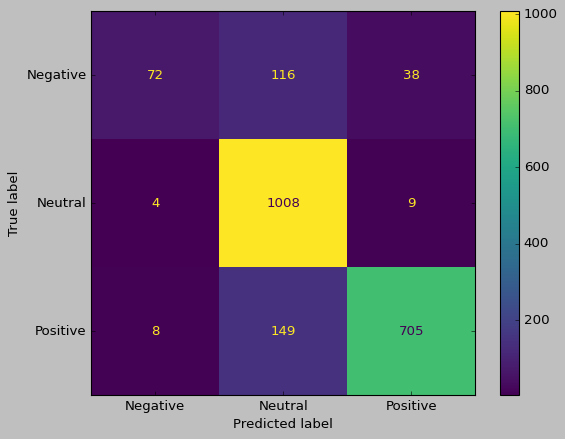

In [40]:
# visulaizing confusion matrix
style.use('classic')
cm=confusion_matrix(y_test,pred,labels=logreg.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg.classes_)
disp.plot()

Hyperparamenter Tuning

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
# set c parameter values
parameter_grid={'C':[0.001,0.01,0.1,1,10]}
grid=GridSearchCV(LogisticRegression(),parameter_grid)
grid.fit(x_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [43]:
print("Best Parameters: ",grid.best_params_)

Best Parameters:  {'C': 10}


In [44]:
y_pred=grid.predict(x_test)

In [45]:
# again checking accuracy of model
accuracy=accuracy_score(y_pred,y_test)
print("Test accuracy: {:.2f}%".format(accuracy*100))

Test accuracy: 86.30%


In [46]:
print(confusion_matrix(y_test,pred))
print("\n")
print(classification_report(y_test,pred))

[[  72  116   38]
 [   4 1008    9]
 [   8  149  705]]


              precision    recall  f1-score   support

    Negative       0.86      0.32      0.46       226
     Neutral       0.79      0.99      0.88      1021
    Positive       0.94      0.82      0.87       862

    accuracy                           0.85      2109
   macro avg       0.86      0.71      0.74      2109
weighted avg       0.86      0.85      0.83      2109



In [47]:
import pickle

In [48]:
# Save the vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vect, f)

# Save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(logreg, f)